In [0]:
import tensorflow as tf;

n_classes = 5
batch_size = 5

x = tf.placeholder('float', name = "MyInput")
#x = tf.placeholder('float')
y = tf.placeholder('float')

def conv2d(x, W):
	return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def maxpool2d(x):
	return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


def convolutional_neural_network(x):
	weights = {'W_conv1': tf.Variable(tf.random_normal([5,5,3,32])),
				'W_conv2': tf.Variable(tf.random_normal([5,5,32,64])),
				'W_fc': tf.Variable(tf.random_normal([5*10*64, 1024])),
				'out': tf.Variable(tf.random_normal([1024, n_classes]))}

	biases = {'b_conv1': tf.Variable(tf.random_normal([32])),
				'b_conv2': tf.Variable(tf.random_normal([64])),
				'b_fc': tf.Variable(tf.random_normal([1024])),
				'out': tf.Variable(tf.random_normal([n_classes]))}

	x= tf.reshape(x, shape=[-1, 20, 40,3])
	conv1 = conv2d(x, weights['W_conv1'])
	conv1 = maxpool2d(conv1)

	conv2= conv2d(conv1, weights['W_conv2'])
	conv2 = maxpool2d(conv2)

	fc= tf.reshape(conv2, [-1,5*10*64])
	fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])

	#fc = tf.nn.dropout(fc, keep_rate)

	output = tf.matmul(fc, weights['out'])+biases['out']
	#output = tf.identity(output, name="MyOutput")
	return output
  


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import tensorflow as tf
import matplotlib
from tensorflow.python.saved_model import tag_constants
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.python.tools import optimize_for_inference_lib, freeze_graph
#mkdir New_model
#!mv saved_model.pb New_model/saved_model.pb

In [0]:
class Generate_from_TFRecord():
	def __init__(self, tfrecord_file):
		self.tfrecord = tfrecord_file

	def extract_image_data(self,batch_size, shuffle):
		def _extract_fn(tfrecord):
			features={
				'image/height': tf.FixedLenFeature([], tf.int64),
				'image/width': tf.FixedLenFeature([], tf.int64),
				'image/image_raw': tf.FixedLenFeature([], tf.string),
				'image/class/label': tf.FixedLenFeature([], tf.int64),
				'image/class/text': tf.FixedLenFeature([], tf.string)}

			sample = tf.parse_single_example(tfrecord, features)

			#image = tf.decode_raw(sample['image/image_raw'],tf.uint8)
			image = tf.image.decode_jpeg(sample['image/image_raw'])
			height = tf.cast(sample['image/height'], tf.int32)
			width = tf.cast(sample['image/width'], tf.int32)
			image = tf.reshape(image,[1,height*width*3])
			#image = tf.reshape(image, [height, width, 3])
			label = tf.cast(sample['image/class/label'], tf.int32)
			label_txt = tf.cast(sample['image/class/text'], tf.string)
			
			return [image, label_txt, label, height, width]

		tfrecord_file = self.tfrecord
		dataset = tf.data.TFRecordDataset([tfrecord_file])
		dataset = dataset.map(_extract_fn)

		if batch_size != None:
			print("Preparing batches.....")
			dataset = dataset.batch(batch_size)
		#dataset = dataset.repeat(10)
		if shuffle == True:
			print("Shuffling.....")
			dataset= dataset.shuffle(buffer_size = len(tfrecord_file))
		return dataset

	def generate_data(self, batch_size = None, shuffle = False):
		print("TFRecord file used: ", self.tfrecord)
		dataset = self.extract_image_data(batch_size, shuffle)
		iterator = dataset.make_one_shot_iterator()
		next_batch = iterator.get_next()
		return next_batch
		

	def get_num_examples(self):
		cnt=0
		imge, text, lab, ht, wdth = self.generate_data()
		with tf.Session() as sess:
			sess.run(tf.initializers.global_variables())
			try:
				while(1):
					img_dat, txt, labl, hgth, wth = sess.run([imge, text, lab, ht, wdth])
					cnt+=1
			except:
				pass
		return cnt


In [0]:
dat = Generate_from_TFRecord('drive/My Drive/Dataset/path_foll_compr_reshaped_more_train.tfrecord')
print('NUMS:: ', dat.get_num_examples())

TFRecord file used:  drive/My Drive/Dataset/path_foll_compr_reshaped_more_train.tfrecord
NUMS::  851


In [0]:
def train_CNN_for_pathFollowing(tfrecordFile,valida_tfrecordFile, batch_size):
  train_data = Generate_from_TFRecord(tfrecordFile)
  train_nums = train_data.get_num_examples()
  
  #train_image, _, train_label,_, _ = train_data.generate_data(batch_size= batch_size)
  #valid_data = Generate_from_TFRecord(valida_tfrecordFile)
  #valid_nums = valid_data.get_num_examples()
  #valid_image, _, valid_label,_, _ = valid_data.generate_data()
  
  print ("Using ", tfrecordFile, "for training and ", valida_tfrecordFile,"for validation")
  
  prediction = convolutional_neural_network(x)
  prediction = tf.identity(prediction, name="myOutput")
	#y_clipped = tf.clip_by_value(prediction, 1e-10, 0.9999999)
	#cost = tf.reduce_mean(tf.reduce_sum(y*tf.log(y_clipped) + (1-y) * tf.log(1-y_clipped), axis = 1))
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))
  optimizer = tf.train.AdamOptimizer().minimize(cost)
	#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)
	# cycles for feed forward and backprop
  hm_epoch = 5
  save_path = "/content/model_final.ckpt"
  saver = tf.train.Saver()
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    total_batch = int(train_nums/batch_size)
    valid_data = Generate_from_TFRecord(valida_tfrecordFile)
    valid_nums = valid_data.get_num_examples()
    valid_image, _, valid_label,_, _ = valid_data.generate_data()
    
    for epoch in range(hm_epoch):
      epoch_loss = 0
      train_data = Generate_from_TFRecord(tfrecordFile)
      train_nums = train_data.get_num_examples()
      train_image, _, train_label,_, _ = train_data.generate_data(batch_size= batch_size)
      
      for _ in range(total_batch):
        epoch_x, epoch_y = sess.run([train_image, train_label])
        #print("Shape:>>>>", epoch_x.shape)
        epoch_y = sess.run(tf.one_hot(epoch_y, depth=5))
        _, c = sess.run([optimizer , cost], feed_dict = {x: epoch_x , y:epoch_y})
        epoch_loss += c
      print ('Epoch ', epoch+1, 'completed out of ', hm_epoch, 'Loss: ', epoch_loss)
    
    correct = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct,'float'))
    inputs={"myInput": x}
    outputs={"myOutput": prediction}
    valid_x=np.array([])
    valid_y=np.array([])
    tf.saved_model.simple_save(sess, '/content/model_more/',inputs, outputs)
    print("saving using Saver::.......................................")
    saver.save(sess, save_path)
    cnc=0
    try:
      while(1):
        cnc+=1
        Vx, Vy = sess.run([valid_image, valid_label])
        Vy = sess.run(tf.one_hot(Vy, depth=5))
        Vy = sess.run(tf.reshape(Vy,[1,len(Vy)]))
        #Vy = Vy.reshape((1,len(Vy)))
        #print(">>",Vx.shape, Vy.shape,valid_x.size==0)
        if valid_x.size==0:
          #valid_x = np.append(valid_x,Vx)
          valid_x = Vx[:]
          #print("<<<>>>", valid_x)
          #valid_x = sess.run(tf.reshape(valid_x,[1,len(valid_x)]))
          valid_y = Vy[:]
          #valid_y = sess.run(tf.reshape(valid_y,[1,len(valid_y)]))
        else:
          #print("Stacking....")
          valid_x = np.append(valid_x,Vx,axis=0)
          valid_y = np.append(valid_y,Vy, axis=0)
        
    except:
      print ("Passing....>.", cnc)
      pass
    print(valid_x.shape)
    print(valid_y.shape)
    print ('Accuracy:: ', accuracy.eval({x:valid_x , y:valid_y}) )
    #saver.save(sess, save_path)
  
validation_tf = 'drive/My Drive/Dataset/path_foll_compr_reshaped_more_validation.tfrecord' 
training_tf = 'drive/My Drive/Dataset/path_foll_compr_reshaped_more_train.tfrecord'
train_CNN_for_pathFollowing(training_tf, validation_tf, batch_size)

TFRecord file used:  drive/My Drive/Dataset/path_foll_compr_reshaped_more_train.tfrecord
Using  drive/My Drive/Dataset/path_foll_compr_reshaped_more_train.tfrecord for training and  drive/My Drive/Dataset/path_foll_compr_reshaped_more_validation.tfrecord for validation
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

TFRecord file used:  drive/My Drive/Dataset/path_foll_compr_reshaped_more_validation.tfrecord
TFRecord file used:  drive/My Drive/Dataset/path_foll_compr_reshaped_more_validation.tfrecord
TFRecord file used:  drive/My Drive/Dataset/path_foll_compr_reshaped_more_train.tfrecord
TFRecord file used:  drive/My Drive/Dataset/path_foll_compr_reshaped_more_train.tfrecord
Preparing batches.....
Epoch  1 completed out of  5 Loss:  559613744.40625
TFRecord file used:  drive/My Drive/Dataset/path_foll_compr_reshaped_more_train.tfrecord
TFRecord 

# **Restoring from saved model.**

In [0]:
validation_tf_vis = 'drive/My Drive/Dataset/path_foll_compr_reshaped_more_validation.tfrecord'
valid_data = Generate_from_TFRecord(validation_tf_vis)
valid_image, _, valid_label,_, _ = valid_data.generate_data()
cn = 0
test_data = np.array([])
test_label = np.array([])
with tf.Session() as sess:
  try:
      while(1):
        cn+=1
        Vx, Vy = sess.run([valid_image, valid_label])
        Vy = sess.run(tf.one_hot(Vy, depth=5))
        Vy = sess.run(tf.reshape(Vy,[1,len(Vy)]))
        if test_data.size==0:
          test_data = Vx[:]
          test_label = Vy[:]
        else:
          test_data = np.append(test_data,Vx,axis=0)
          test_label = np.append(test_label,Vy, axis=0)
  except:
    print ("Passing..", cn)
    pass

TFRecord file used:  drive/My Drive/Dataset/path_foll_compr_reshaped_more_validation.tfrecord
Passing.. 47


In [0]:
'''
tf.reset_default_graph()
imported_meta = tf.train.import_meta_graph("model_final.ckpt.meta")
#x = tf.placeholder('float')
#y = tf.placeholder('float')
#prediction = convolutional_neural_network(x) 
with tf.Session() as sess:
  imported_meta.restore(sess,tf.get.latest_checkpoint('./'))
  #print(sess.run('valix_x')) 
  corr = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
  accu = tf.reduce_mean(tf.cast(correct,'float'))
  print ('Accuracy:: ', accu.eval({x:data.test , y:data_label, session=sess}) )
  #prediction=tf.argmax(y,1)
  #print (prediction.eval(feed_dict={x: test_data, },session=sess))

'''
'''
saver = tf.train.import_meta_graph("model_final.ckpt.meta")
graph = tf.get_default_graph()

x = graph.get_tensor_by_name('output/BiasAdd:0')
print (x.type)
'''
#tf.saved_model.loader.load(sess, [tag_constants.SERVING],'/content/New_model/model/' )
gr=tf.Graph()
ip = tf.placeholder('float')
prediction = tf.placeholder('float')
save_path = '/content/model.ckpt'
#with graph.as_default():
with tf.Session() as sess:
  tf.saved_model.loader.load(sess, [tag_constants.SERVING],'/content/model/' )
  gr =  tf.get_default_graph()
  ip = gr.get_tensor_by_name('MyInput:0') 
  print("Input shape: ",ip.shape)
  prediction = gr.get_tensor_by_name('myOutput:0')
  print("OP shape: ",prediction.shape)
  #print(sess.run(graph.is_feedable('myOutput:0')))
  print (sess.run(prediction, feed_dict={ip:test_data[6]}))
  #print (sess.run('myOutput:0', feed_dict={'MyInput:0':test_data}))


INFO:tensorflow:Restoring parameters from /content/model/variables/variables
Input shape:  <unknown>
OP shape:  (?, 5)
[[1.2606353e+07 1.6259604e+06 1.2832307e+08 8.8431940e+06 3.3300906e+08]]


In [0]:
!mkdir ckpt
!mv checkpoint ckpt/
!mv model_f* ckpt/

In [0]:
!tar -czvf model.tar.gz model_more/
#!mv '/content/ckpt/model_more' '/content/'
#from google.colab import files
#files.download('model.tar.gz')
#!cp model.tar.gz 'drive/My Drive/Dataset/'
!tar -czvf ckpt.tar.gz ckpt/



model_more/
model_more/variables/
model_more/variables/variables.data-00000-of-00001
model_more/variables/variables.index
model_more/saved_model.pb
ckpt/
ckpt/checkpoint
ckpt/model_final.ckpt.meta
ckpt/model_final.ckpt.index
ckpt/model_final.ckpt.data-00000-of-00001


In [0]:
predict = tf.contrib.predictor.from_saved_model('/content/model/')
#x = tf.placeholder('float')
#print (predict({"myInput":test_data[6]}))

INFO:tensorflow:Restoring parameters from /content/model/variables/variables


In [0]:
op = predict({"myInput":test_data[35]})
print (np.argmax(op['myOutput']))
#print(predict({"myInput":test_data[6]}))
#with tf.Session() as sess:
#  print (sess.run(tf.argmax(predict({"myInput":test_data[6]}),1) ))

4


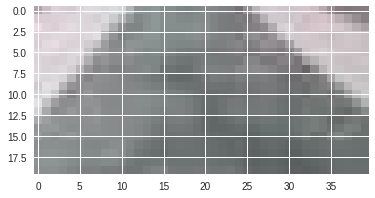

In [0]:
#print (test_data[0].shape)

imageToUse = test_data[32]
plt.figure()
plt.imshow(np.reshape(imageToUse,[20,40,3]), interpolation="nearest", cmap="gray", )
plt.show()

In [0]:
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
from googleapiclient.http import MediaFileUpload

file_metadata = {
  'name': 'Sample file',
  'mimeType': 'text/plain'
}
media = MediaFileUpload('/content/ckpt.tar.gz', 
                        mimetype='application/tar+gzip',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))

File ID: 1vNUd_vaWvllTs25NxQVYSLfYClxbuJxP


#Freeze a graph


In [0]:
#!mv /content/ckpt/freeze_mod.py /content/
!cp -r drive/My\ Drive/Dataset/ckpt/* /content/

In [0]:
!python3 freeze_mod.py --model_dir='/content/' --output_node_names=myOutput

2018-11-20 04:40:53.934081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:964] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-11-20 04:40:53.934555: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
totalMemory: 11.17GiB freeMemory: 10.79GiB
2018-11-20 04:40:53.934604: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2018-11-20 04:40:54.370690: I tensorflow/core/common_runtime/gpu/gpu_device.cc:982] Device interconnect StreamExecutor with strength 1 edge matrix:
2018-11-20 04:40:54.370765: I tensorflow/core/common_runtime/gpu/gpu_device.cc:988]      0 
2018-11-20 04:40:54.370792: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1001] 0:   N 
2018-11-20 04:40:54.371110: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc

In [0]:
import os
os.listdir('/content/ckpt/')

['checkpoint',
 'model_final.ckpt.meta',
 'model_final.ckpt.index',
 'model_final.ckpt.data-00000-of-00001']

#Load Frozen Graph

In [0]:
def load_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we import the graph_def into a new Graph and returns it 
    with tf.Graph().as_default() as graph:
        # The name var will prefix every op/nodes in your graph
        # Since we load everything in a new graph, this is not needed
        tf.import_graph_def(graph_def, name="prefix")
    return graph


gr = load_graph('frozen_model.pb')
#op = predict({"myInput":test_data[35]})
#print (np.argmax(op['myOutput']))
print (gr)

In [0]:
##### Get list of operations and variables#######
for op in gr.get_operations():
  print(op.name)



prefix/MyInput
prefix/Variable
prefix/Variable/read
prefix/Variable_1
prefix/Variable_1/read
prefix/Variable_2
prefix/Variable_2/read
prefix/Variable_3
prefix/Variable_3/read
prefix/Variable_6
prefix/Variable_6/read
prefix/Variable_7
prefix/Variable_7/read
prefix/Reshape/shape
prefix/Reshape
prefix/Conv2D
prefix/MaxPool
prefix/Conv2D_1
prefix/MaxPool_1
prefix/Reshape_1/shape
prefix/Reshape_1
prefix/MatMul
prefix/add
prefix/Relu
prefix/MatMul_1
prefix/add_1
prefix/myOutput


In [0]:
ip = gr.get_tensor_by_name('prefix/MyInput:0')
prediction = gr.get_tensor_by_name('prefix/myOutput:0')


In [0]:
with tf.Session(graph=gr) as sess:
  op = sess.run(prediction, feed_dict={ip:test_data[32]})
  print (np.argmax(op))

1


#Optimizing For Inference

In [0]:
!python -m tensorflow.python.tools.optimize_for_inference --input=frozen_model.pb --output=optimized_graph.pb --input_names="MyInput" --output_names="myOutput"

In [0]:
with tf.gfile.GFile('optimized_graph.pb', 'rb') as f:
   graph_def_optimized = tf.GraphDef()
   graph_def_optimized.ParseFromString(f.read())

G = tf.Graph()

with tf.Session(graph=G) as sess:
    y, = tf.import_graph_def(graph_def_optimized, return_elements=['myOutput:0'])
    print('Operations in Optimized Graph:')
    print([op.name for op in G.get_operations()])
    x = G.get_tensor_by_name('import/MyInput:0')
    prediction = G.get_tensor_by_name('import/myOutput:0')
    op = sess.run(prediction, feed_dict={x:test_data[10]})
    print (np.argmax(op))